In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import numpy as np
import json
from transformers import AutoTokenizer
# from crosscoder_learning.dictionary_learning.cache import ActivationCache

import os
import torch
import torch.nn.functional as F

In [12]:
MODEL = 'llama'

prompt_cat = "no_refusal"

if MODEL == 'llama':
    model_path = "../Llama-3.2-3B-Instruct/"    
    layers = [i for i in range(11,21,2)]
    MODEL_DIM = 3072
else:
    model_path = "../Llama-3.1-8B-Instruct/"
    layers = [i for i in range(12,20,2)]
    MODEL_DIM = 4096

In [13]:
layers

[11, 13, 15, 17, 19]

In [14]:
import os
import torch
import torch.nn.functional as F

ckpt_dir_refusal = f"../outputs/probe_checkpoints/controlling_probe/refusal/{MODEL}/PRE_ASSISTANT"
ckpt_dir_no_refusal = f"../outputs/probe_checkpoints/controlling_probe/no_refusal/{MODEL}/PRE_ASSISTANT"

cossim_by_layer = {}

for layer in layers:
    # ---------------------------
    # Load refusal probe
    # ---------------------------
    ckpt_refusal = os.path.join(
        ckpt_dir_refusal,
        f"trust_probe_at_layer_{layer}_final.pth",
    )
    probe_refusal = torch.load(ckpt_refusal, map_location="cpu")

    diff0_r = probe_refusal["proj.0.weight"][0]
    diff1_r = probe_refusal["proj.0.weight"][1]
    trust_refusal = diff1_r - diff0_r

    # ---------------------------
    # Load no-refusal probe
    # ---------------------------
    ckpt_no_refusal = os.path.join(
        ckpt_dir_no_refusal,
        f"trust_probe_at_layer_{layer}_final.pth",
    )
    probe_no_refusal = torch.load(ckpt_no_refusal, map_location="cpu")

    diff0_nr = probe_no_refusal["proj.0.weight"][0]
    diff1_nr = probe_no_refusal["proj.0.weight"][1]
    trust_no_refusal = diff1_nr - diff0_nr

    # ---------------------------
    # Cosine similarity
    # ---------------------------
    cossim = F.cosine_similarity(
        trust_refusal.unsqueeze(0),
        trust_no_refusal.unsqueeze(0),
        dim=1
    ).item()

    cossim_by_layer[layer] = cossim

# sort by layer index
cossim_by_layer = dict(sorted(cossim_by_layer.items()))

In [15]:
cossim_by_layer

{11: 0.9177308082580566,
 13: 0.90816730260849,
 15: 0.9060140252113342,
 17: 0.8993799090385437,
 19: 0.8901345133781433}

In [6]:
ckpt_dir = f"probe_checkpoints/controlling_probe/{prompt_cat}/{MODEL}/PRE_ASSISTANT"

cossim_by_layer = {}

for layer in layers:
    ckpt_path = os.path.join(
        ckpt_dir,
        f"trust_probe_at_layer_{layer}_final.pth",
    )

    ref_dir = f"refusal_svs/{MODEL}/sv_layer_{layer}.pt"

    probe = torch.load(ckpt_path, map_location="cpu")
    refusal_vector = torch.load(ref_dir, map_location="cpu")

    diff_0 = probe['proj.0.weight'][0]
    diff_1 = probe['proj.0.weight'][1]
    trust_vector = diff_1 - diff_0

    # ensure 1D + normalized cosine similarity
    cossim = F.cosine_similarity(
        trust_vector.unsqueeze(0),
        refusal_vector.unsqueeze(0),
        dim=1
    ).item()

    cossim_by_layer[layer] = cossim

# optional: sort by layer index
cossim_by_layer = dict(sorted(cossim_by_layer.items()))


FileNotFoundError: [Errno 2] No such file or directory: 'probe_checkpoints/controlling_probe/no_refusal/llama/PRE_ASSISTANT/trust_probe_at_layer_11_final.pth'

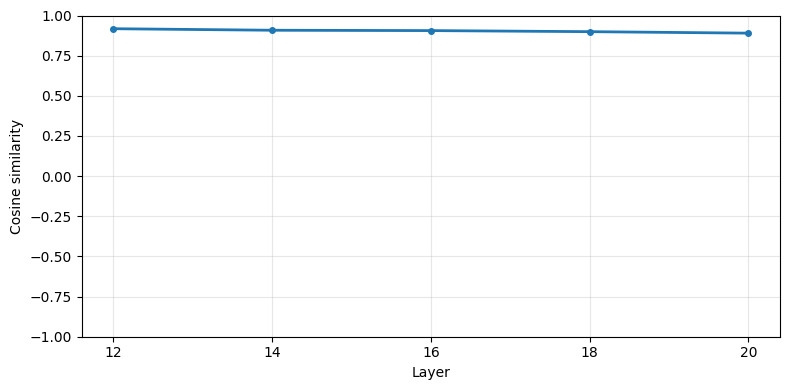

Saved plot to ../outputs/plots/trust_ref_noref__cossim_by_layer_llama.png


In [16]:
import matplotlib.pyplot as plt

layers = list(cossim_by_layer.keys())
cossims = list(cossim_by_layer.values())

plt.figure(figsize=(8, 4))  # slimmer aspect for blogs

plt.plot(
    layers,
    cossims,
    marker='o',
    linewidth=2,
    markersize=4
)

plt.xlabel("Layer")
plt.ylabel("Cosine similarity")

plt.xticks(layers, [l + 1 for l in layers])
plt.ylim(-1.0, 1.0)

# subtle grid, blog-friendly
plt.grid(True, alpha=0.3)

# minimal title (optional)
# plt.title("Trust vs Refusal Direction Alignment")

plt.tight_layout()

# save for blog
save_path = f"../outputs/plots/trust_ref_noref__cossim_by_layer_{MODEL}.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved plot to {save_path}")